In [1]:
import pandas as pd
import spacy 
nlp = spacy.load('en')

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter 
from bs4 import BeautifulSoup 
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
stop = set(stopwords.words('english'))

import pickle

def dump(obj,filename):
    filehandler = open(filename,"wb")
    pickle.dump(obj,filehandler)
    filehandler.close()

def load(filename):
    file = open(filename,'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Preprocessing | Choose xlsx or dataframe

In [4]:
# READS THE EXCEL FILE
# INSTEAD OF FILE, WE SHOULD BE PASSING DATAFRAMES (FOR THE SELECTION OF SOURCES)
conversations = pd.read_excel('../../Coke vs Pepsi Twitter Data for NLP 1.xlsx')
# DROPS THE EMPTY OBSERVATIONS. ARE WE SUPPOSED TO DO THAT IN THIS CASE? THERE ARE NO BLANK TEXTS IN THIS SET
conversations = conversations.dropna(subset=['Sound Bite Text'])

In [ ]:
# OR dataframe
conversations = load("../corpus_doc.pkl")

#### Function to Clean Text used later

In [6]:
# CLEANS TEXT BY REPLACING CHARACTERS
def getCleanText(text, lower = True):
    text = str(text)
    parse_text = BeautifulSoup(text).get_text()
    letters_only = re.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' url ', 
                          parse_text, flags=re.MULTILINE)
    letters_only = re.sub('^(1?[0-9]|2[0-3]):[0-5][0-9]$','time',letters_only)
    letters_only = re.sub('(name|NAME)\d{1,}','username',letters_only)
    letters_only = re.sub("[^a-zA-Z0-9\.:']",  
                      " ",                   
                      letters_only)
    letters_only = letters_only.replace('\n'," ")
    letters_only = letters_only.replace('\r'," ")
    letters_only = re.sub('[.]{2,}', '. ', letters_only)
    if lower:
        letters_only = letters_only.lower()
    words = CountVectorizer(stop_words='english').build_tokenizer()(letters_only)
    meaningful_words = [ w for w in words if len(w)> 0 and len(w)<20]
    clean_text = " ".join(meaningful_words)
    return clean_text

In [7]:
#define some parameters  
noisy_pos_tags = ['PROP'] # TAGGING OF PROP
min_token_length = 2 # TWO CHARACTERS OR TWO TOKENS?

#Function to check if the token is a noise or not  
def isNoise(token):     
    is_noise = False
    if token.pos_ in noisy_pos_tags: # FROM LIST ABOVE
        is_noise = True 
    elif token.is_stop == True: # FROM STOP WORDS LIST 
        is_noise = True
    elif len(token.string) <= min_token_length: # FROM PARAMETER ABOVE
        is_noise = True
    return is_noise 
def cleanup(token, lower = True):
    if lower: # TURNS ALL TEXT TO LOWERCASE
        token = token.lower()
    return token.strip() # REMOVES SPACES FROM THE BEGINNING AND END

### Named Entity Recognition

In [10]:
def get_entities(sent):
    #sentence = unicode(sent.decode('utf8'))
    sentence = sent#.decode('utf8')
    try:
        document = nlp(sentence)
    except:
        return ["error"]
    entities_list = []
    labels = set([w.label_ for w in document.ents]) 
    for label in labels: 
        entities = [cleanup(e.string, lower=False) for e in document.ents if label==e.label_] 
        entities = list(set(entities))
        #Here Labels is ORG if you dont specify this it will give you all entities which we want, 
        #keep the labels as well to explore
        if label == "ORG": # I HAVE TO PLAY WITH THESE LABELS TO EXTRACT THE CORRECT ENTITIES
            entities_list.append(entities)
    if len(entities_list) > 0:
        return entities_list
    else:
        return ["Blank"]
#org_list = map(get_entities, conversations)#NAMED entity rowwise 
org_list = map(get_entities, conversations["Sound Bite Text"])#NAMED entity rowwise 

### Extraction of Named Entities

In [11]:
# SIMPLY EXTRACTS THE LIST FROM THE MAP
all_orgs = []
for orga in org_list:
    if orga == ['Blank']:
        orga = [orga]
    all_orgs+=orga

In [12]:
# CREATES A LIST WITH ELEMENTS INSTEAD OF LISTS
flat_list = [item for sublist in all_orgs for item in sublist]

In [13]:
# CLEANS THE LIST OF ELEMENTS
all_orgs_clean = map(getCleanText, flat_list)

### Count of Named Entitites

In [14]:
# COUNTS AND ORDER INDIVIDUAL ENTITIES FOUND IN THE ENTIRE CORPUS
entities_dict = Counter(all_orgs_clean)
entities_list_sorted = sorted(entities_dict, key = entities_dict.get, reverse=True)
entities_list_sorted_tup = [(entities,entities_dict[entities]) for entities in entities_list_sorted]
entities_list_sorted_tup

/home/k/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/k/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/home/k/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/k/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.youtube.com" looks like a URL. Beautiful Soup is n

[('blank', 26144),
 ('coca cola', 25585),
 ('pepsi', 22196),
 ('coke', 9487),
 ('coca cola company', 2793),
 ('beyonc', 2678),
 ('coca', 2666),
 ('super bowl', 2663),
 ('britneyspears', 2518),
 ('black', 2110),
 ('mcdonalds', 1468),
 ('nfl', 1369),
 ('chrtistians', 1273),
 ('apocalypse', 1273),
 ('', 1103),
 ('mcdonald', 1063),
 ('pepsico', 959),
 ('the coca cola company', 877),
 ('nyse', 801),
 ('coca cola co', 734),
 ('apple', 593),
 ('company', 567),
 ('microsoft', 564),
 ('pepsi cola', 538),
 ('diet', 488),
 ('coke zero sugar', 459),
 ('fifa', 448),
 ('nestle', 427),
 ('brigham young university', 412),
 ('llc', 395),
 ('chocolate', 378),
 ('google', 356),
 ('nike', 334),
 ('inc', 312),
 ('coke zero', 310),
 ('coca cola femsa', 304),
 ('coca cola european partners plc', 300),
 ('diet coke', 296),
 ('ford', 284),
 ('cce', 277),
 ('un rt', 266),
 ('ap', 264),
 ('hyundai motor america', 261),
 ('coca cola zero sugar', 260),
 ('the company', 260),
 ('britney beyonce', 259),
 ('kellogg',

In [ ]:
# SAVES PICKLE FILES
dump(entities_list_sorted_tup, "individual_entities_list_data.pkl")
dump(all_orgs,"list_entities_per_doc_data.pkl")

### GRAPH

In [15]:
# ITERATOR TO MAP ENTITY AND VALUE
entities = map(lambda x:x[0] , entities_list_sorted_tup)
entities_count = map(lambda x: x[1], entities_list_sorted_tup)

In [16]:
entities_count_df = pd.DataFrame(data = entities_list_sorted_tup)
entities_count_df.size
entities_count_df.columns = ["Entity", "Count"]

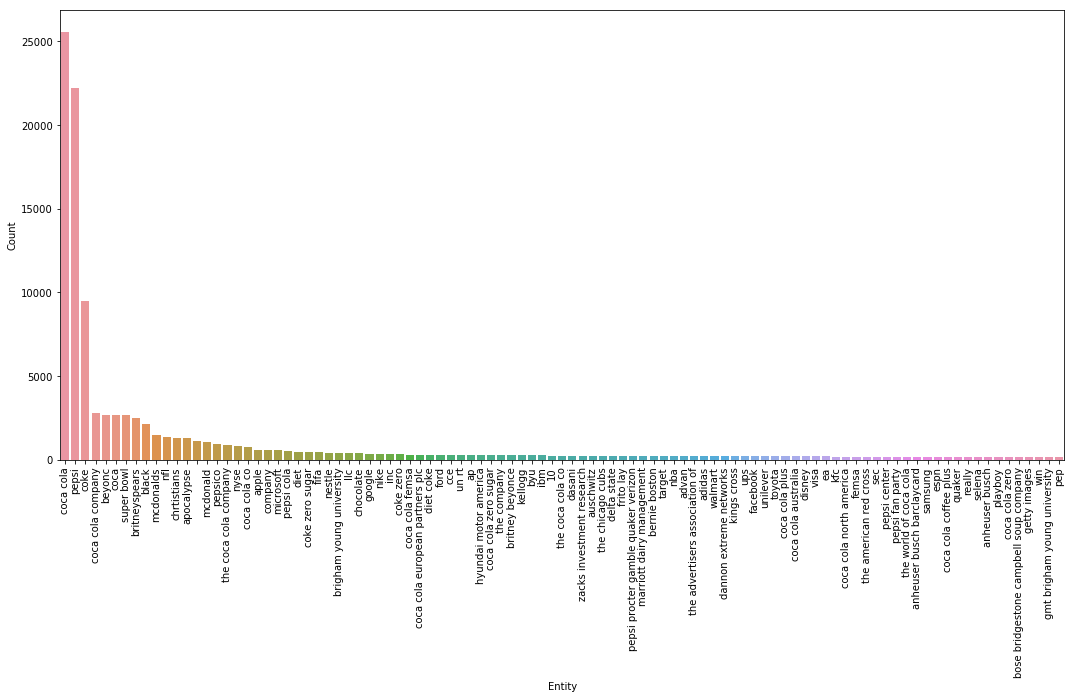

In [17]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(18, 8.27)
ax = sns.barplot(x="Entity", y="Count", data = entities_count_df[1:100])
_ = plt.xticks(rotation=90)